In [1]:
!pip install simpy


In [2]:
import time
from collections import Counter
import pandas as pd

# Simulador de n cantidad de barcos atendidos con una tasa a determinar.

Se pasan por parámetros:
 Barcos a simular
 Rendimiento de la grua por hora
 cantidad de gruas
 tasa de llegada de los barcos a premar

In [3]:
import simpy
import numpy as np
import random
from collections import Counter
import random
import pandas as pd

In [4]:
class Buque:
    def __init__(self, id_buque):
        self.id = id_buque

        # Generar aleatoriamente la cantidad de contenedores para carga y descarga
        self.descargar = random.randint(200, 1200)  # Descarga entre 200 y 1200 contenedores
        self.cargar = random.randint(100, 600)  # Carga entre 100 y 600 contenedores
        self.num_contenedores = self.cargar + self.descargar  # Total de contenedores

        # Crear contenedores con tipos aleatorios
        self.contenedores = [Contenedor(tipo=np.random.choice(['liviano', 'mediano', 'pesado'])) for _ in range(self.num_contenedores)]

        # Calcular el peso total del buque
        self.peso_total = sum([c.peso for c in self.contenedores])

    def resumen(self):
        return {
            "id": self.id,
            "num_contenedores": self.num_contenedores,
            "cargar": self.cargar,
            "descargar": self.descargar,
            "peso_total": self.peso_total
        }

class Contenedor:
    # Peso promedio de los contenedores según tipo
    clases_peso = {
        'liviano': random.randint(5, 10),  # peso promedio
        'mediano': random.randint(11, 16),
        'pesado': random.randint(17, 22),
    }

    def __init__(self, tipo):
        # Tipo de contenedor (liviano, mediano, pesado)
        self.tipo = tipo

        # Distribución binomial para decidir si el contenedor está lleno o medio lleno
        self.lleno = random.choices([True, False], weights=[0.7, 0.3])[0]  # 80% lleno, 20% medio lleno

        # Obtener peso base según tipo
        self.peso_base = self.clases_peso[self.tipo]  # Peso base dependiendo del tipo

        # Si está medio lleno, el peso es la mitad
        self.peso = self.peso_base if self.lleno else self.peso_base / 2

In [5]:
def operar_buque(env, buque, gruas, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion):
    llegada = env.now
    buque.tiempo_llegada = llegada  # guardar si querés usar luego

    # 1️⃣ Llegada a pre mar
    eventos.append((env.now, 'start', buque.id))


    print(f"{env.now:.2f} - Buque {buque.id} llegó a altamar y espera una grúa")
            # Calcular tiempo estimado en horas

    with gruas.request() as req:
        yield req
        inicio_navegacion = env.now
        espera =  inicio_navegacion - llegada

        print(f"{env.now:.2f} - Buque {buque.id} accede a grúa tras {espera:.2f} horas")

        ### Bloque navegacion ###
        # 2️⃣ Espera termina → es seleccionado por grúa
        eventos.append((env.now, 'b', buque.id))
        # Simular tiempo de navegación de la grúa (en horas)
        tiempo_navegacion = np.random.uniform(15/60, 30/60)
        tiempo_ocioso = max(0, env.now - grua_ts[0])# tiempo desde última operación hasta ahora
        print(f"{env.now:.2f} - Buque {buque.id} navega por {tiempo_navegacion:.2f} horas de espera en pre mar")


        yield env.timeout(tiempo_navegacion)   #Pausa el tiempo del sistema... del buque.


        inicio_servicio =  env.now
        # 5️⃣ Inicio servicio
        eventos.append((env.now, 'c', buque.id))

        ##################################

        ## Bloque grua ##
        print(f"{env.now:.2f} - Buque {buque.id} comienza a ser atendido por una grúa... posee {buque.num_contenedores} contenedores")

        ## La duración en horas es la relación entre la cantidad de contendeores y el rendimiento hora. Se asume que tarda lo mismo por contenedor. Podemos diverisifcarlo en liviano, mediano y pesado
        duracion = buque.num_contenedores / rendimiento  #rendimiento_grua_tn_hora es la tasa de atención de la grua por hora.
        peso_x_hora = (buque.peso_total) / rendimiento # Rendimiento de la grua por hora segun peso

        # Posible rotura
        probabilidad_rotura_total = 0
        contenedor_que_rompe = None  # Variable para almacenar el contenedor que causa la rotura

        for contenedor in buque.contenedores:
            probabilidad_rotura = calcular_probabilidad_rotura(contenedor)
            probabilidad_rotura_total += probabilidad_rotura

            # Si la rotura ocurre, almacenamos el contenedor que la causó
            if np.random.random() < probabilidad_rotura:
                contenedor_que_rompe = contenedor

        # Promediamos la probabilidad de rotura por el número de contenedores
        probabilidad_media = probabilidad_rotura_total / buque.num_contenedores

        if np.random.random() < probabilidad_media:
            print(f"{env.now:.2f} - ¡Grúa se rompe durante el servicio del buque {buque.id}!")

            # Determinar el tiempo de reparación según el tipo de contenedor que causó la rotura
            if contenedor_que_rompe.tipo == "liviano":
                duracion += np.random.uniform(1, 2)  # Entre 1 y 2 horas
            elif contenedor_que_rompe.tipo == "mediano":
                duracion += np.random.uniform(3, 5)  # Entre 3 y 5 horas
            elif contenedor_que_rompe.tipo == "pesado":
                duracion += np.random.uniform(6, 8)  # Entre 6 y 8 horas
            reparacion = 1
        else:
            reparacion = 0

        yield env.timeout(duracion)



        grua_ts[0] = env.now


####### Se corre un contador de barcos servidos.. se van sirviendo barcos a medida que van llegando.

        barcos_servidos[0] += 1
        if barcos_servidos[0] >= BARCOS_A_SERVIR and not fin_simulacion.triggered:
          fin_simulacion.succeed()

        #print(grua_ts[0])
        print(f"{env.now:.2f} - Buque {buque.id} termina operación y libera grúa")

        # 6️⃣ Fin servicio
        eventos.append((env.now, 'end', buque.id))

        # Actualiza el momento en que la grúa queda libre

        conteo = Counter([c.tipo for c in buque.contenedores])  # Contamos las clases de cada contenedor
        proporciones = {k: round(v / buque.num_contenedores, 2) for k, v in conteo.items()}

        # Contenedores medio llenos
        contenedores_medio_llenos = [c for c in buque.contenedores if not c.lleno]
        cant_medio_llenos = len(contenedores_medio_llenos)
        peso_total_medio_llenos = sum(c.peso for c in contenedores_medio_llenos)
        proporcion_medio_llenos = round(cant_medio_llenos / buque.num_contenedores, 2)
        peso_promedio_medio_llenos = round(peso_total_medio_llenos / cant_medio_llenos, 2) if cant_medio_llenos > 0 else 0



        # 7️⃣ Navegación de salida
        tiempo_salida = np.random.uniform(10/60, 20/60)
        yield env.timeout(tiempo_salida)

        log.append({
            "id": buque.id,
            'llegada(ts)':llegada,
            "hora_navegacion_inicio(ts)": inicio_navegacion,
            "tiempo_navegacion": tiempo_navegacion+tiempo_salida,
            "inicio_servicio(ts)": inicio_servicio,
            "fin_servicio(ts)": env.now,
            "tiempo_espera": espera,
            "tiempo_servicio": duracion,
            'tiempo_ocioso': tiempo_ocioso + tiempo_navegacion,
            "peso_total_operado": buque.peso_total,
            "peso_x_hora": round(peso_x_hora, 2),  # Está relativamente inflado
            "clases_contenedores": proporciones,
            "contenedores_carga": buque.cargar,
            "contenedores_descarga": buque.descargar,
            'contenedores_total': buque.num_contenedores,
            "proporcion_carga": round(buque.cargar / (buque.cargar + buque.descargar), 2) if (buque.cargar + buque.descargar) > 0 else 0,
            "medio_llenos": cant_medio_llenos,
            "peso_medio_llenos_total": peso_total_medio_llenos,
            "peso_medio_por_medio_lleno": peso_promedio_medio_llenos,
            "proporcion_medio_llenos": proporcion_medio_llenos,
            "reparacion": reparacion,
            'buque_espero_T_F': False if espera == 0 else True,
            'grua_ocioso_T_F': True if tiempo_ocioso != 0 else False,
            'ciclo': simulacion
        })

In [6]:
# Probabilidades de rotura por clase de contenedor
x = 0.1  # Probabilidad de rotura para contenedor liviano
y = 0.15  # Probabilidad de rotura para contenedor mediano
z = 0.20  # Probabilidad de rotura para contenedor pesado

# Lógica para calcular la probabilidad de rotura según el tipo de contenedor
def calcular_probabilidad_rotura(contenedor):
    if contenedor.tipo == "liviano":
        probabilidad_rotura = x
    elif contenedor.tipo == "liviano_medio_lleno":
        probabilidad_rotura = 0.75 * x
    elif contenedor.tipo == "mediano":
        probabilidad_rotura = y
    elif contenedor.tipo == "mediano_medio_lleno":
        probabilidad_rotura = 0.75 * y
    elif contenedor.tipo == "pesado":
        probabilidad_rotura = z
    elif contenedor.tipo == "pesado_medio_lleno":
        probabilidad_rotura = 0.75 * z
    else:
        probabilidad_rotura = 0  # Si no es ningún tipo definido, no hay probabilidad de rotura

    return probabilidad_rotura

def operar_buque(env, buque, gruas, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion):
    llegada = env.now
    buque.tiempo_llegada = llegada  # guardar si querés usar luego
    print(f"{env.now:.2f} - Buque {buque.id} llegó a altamar y espera una grúa")
            # Calcular tiempo estimado en horas

    with gruas.request() as req:
        yield req
        assert gruas.count <= gruas.capacity, "No hay gruas disponibles"
        inicio_navegacion = env.now
        espera =  inicio_navegacion - llegada
        assert espera >= 0, "El tiempo de espera no puede ser negativo"
        print(f"{env.now:.2f} - Buque {buque.id} accede a grúa tras {espera:.2f} horas")

        ### Bloque navegacion ###

        # Simular tiempo de navegación de la grúa (en horas)
        tiempo_navegacion = np.random.uniform(15/60, 30/60) # el tiempo de navegacion es el tiempo entre inicio de navegacion hasta el amarre del barco
        tiempo_ocioso = max(0, env.now - grua_ts[0])# tiempo desde última operación hasta ahora
        assert grua_ts[0]>=0, "El tiempo no puede ser negativo"
        print(f"{env.now:.2f} - Buque {buque.id} navega por {tiempo_navegacion:.2f} horas de espera en pre mar")
        yield env.timeout(tiempo_navegacion)   #Pausa el tiempo del sistema... del buque.
        inicio_servicio =  env.now
        ##################################

        ## Bloque grua ##
        print(f"{env.now:.2f} - Buque {buque.id} comienza a ser atendido por una grúa... posee {buque.num_contenedores} contenedores")

        ## La duración en horas es la relación entre la cantidad de contendeores y el rendimiento hora. Se asume que tarda lo mismo por contenedor. Podemos diverisifcarlo en liviano, mediano y pesado
        duracion = buque.num_contenedores / rendimiento  #rendimiento_grua_tn_hora es la tasa de atención de la grua por hora.
        assert 200 <= buque.descargar <= 1200, "La cantidad de contenedores de descarga debe estar entre 200 y 1200"
        assert 100 <= buque.cargar <= 600, "La cantidad de contenedores de carga debe estar entre 100 y 600"
        assert buque.num_contenedores == buque.cargar + buque.descargar, "La cantidad de contenedores de carga y descarga no coinciden"

        peso_x_hora = (buque.peso_total)/duracion # Rendimiento de la grua por hora segun peso

        # Posible rotura
        probabilidad_rotura_total = 0
        contenedor_que_rompe = None  # Variable para almacenar el contenedor que causa la rotura

        for contenedor in buque.contenedores:
            probabilidad_rotura = calcular_probabilidad_rotura(contenedor)
            probabilidad_rotura_total += probabilidad_rotura

            # Si la rotura ocurre, almacenamos el contenedor que la causó
            if np.random.random() < probabilidad_rotura:
                contenedor_que_rompe = contenedor

        # Promediamos la probabilidad de rotura por el número de contenedores
        probabilidad_media = probabilidad_rotura_total / buque.num_contenedores

        if np.random.random() < probabilidad_media:
            print(f"{env.now:.2f} - ¡Grúa se rompe durante el servicio del buque {buque.id}!")

            # Determinar el tiempo de reparación según el tipo de contenedor que causó la rotura
            if contenedor_que_rompe.tipo == "liviano":
                duracion += np.random.uniform(1, 2)  # Entre 1 y 2 horas
            elif contenedor_que_rompe.tipo == "mediano":
                duracion += np.random.uniform(3, 5)  # Entre 3 y 5 horas
            elif contenedor_que_rompe.tipo == "pesado":
                duracion += np.random.uniform(6, 8)  # Entre 6 y 8 horas
            reparacion = 1
        else:
            reparacion = 0

        yield env.timeout(duracion)
        grua_ts[0] = env.now

        assert env.now >= llegada, "El tiempo actual no puede ser menor a la llegada"
        tiempo_total = round(env.now - llegada, 3)
        suma = round(espera + tiempo_navegacion + duracion,3)
        assert tiempo_total >= suma, "El tiempo total es menor a la suma de sus partes"

####### Se corre un contador de barcos servidos.. se van sirviendo barcos a medida que van llegando.

        barcos_servidos[0] += 1
        if barcos_servidos[0] >= BARCOS_A_SERVIR and not fin_simulacion.triggered:
          fin_simulacion.succeed()

        #print(grua_ts[0])
        print(f"{env.now:.2f} - Buque {buque.id} termina operación y libera grúa")

        # Actualiza el momento en que la grúa queda libre

        assert buque.num_contenedores > 0, "No puede haber buqes sin contenedores"
        assert buque.peso_total > 0, "El peso del buque debe ser positivo"

        conteo = Counter([c.tipo for c in buque.contenedores])  # Contamos las clases de cada contenedor
        proporciones = {k: round(v / buque.num_contenedores, 2) for k, v in conteo.items()}

        assert all(0 <= p <= 1 for p in proporciones.values()), "Las proporciones de contenedores deben estar entre 0 y 1"
        assert sum(proporciones.values()) <= 1.03, "La suma de proporciones supera 1" # le agregamos una toleracia a redondeo
        assert sum(conteo.values())==buque.num_contenedores, "Hay mas contenedores de lo previsto"

        # Contenedores medio llenos
        contenedores_medio_llenos = [c for c in buque.contenedores if not c.lleno]
        cant_medio_llenos = len(contenedores_medio_llenos)
        peso_total_medio_llenos = sum(c.peso for c in contenedores_medio_llenos)
        proporcion_medio_llenos = round(cant_medio_llenos / buque.num_contenedores, 2)
        peso_promedio_medio_llenos = round(peso_total_medio_llenos / cant_medio_llenos, 2) if cant_medio_llenos > 0 else 0

        # 7️⃣ Navegación de salida
        tiempo_salida = np.random.uniform(10/60, 30/60)

        log.append({
            "id": buque.id,
            'llegada(ts)':llegada,
            "hora_navegacion_inicio(ts)": inicio_navegacion,
            "tiempo_navegacion": tiempo_navegacion + tiempo_salida,
            "inicio_servicio(ts)": inicio_servicio,
            "fin_servicio(ts)": env.now,
            "tiempo_espera": espera,
            "tiempo_servicio": duracion,
            'tiempo_ocioso': tiempo_ocioso,
            'tiempo_total_operacion':env.now-llegada,
            "peso_total_operado": buque.peso_total,
            "peso_x_hora": round(peso_x_hora, 2),  # Está relativamente inflado
            "clases_contenedores": proporciones,
            "contenedores_carga": buque.cargar,
            "contenedores_descarga": buque.descargar,
            'contenedores_total': buque.num_contenedores,
            "proporcion_carga": round(buque.cargar / (buque.cargar + buque.descargar), 2) if (buque.cargar + buque.descargar) > 0 else 0,
            "medio_llenos": cant_medio_llenos,
            "peso_medio_llenos_total": peso_total_medio_llenos,
            "peso_x_hora_medio_lleno": peso_total_medio_llenos / rendimiento,
            "proporcion_medio_llenos": proporcion_medio_llenos,
            "reparacion": reparacion,
            'buque_espero_T_F': False if espera == 0 else True,
            'grua_ocioso_T_F': True if tiempo_ocioso != 0 else False,
            'ciclo': simulacion
        })

def generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion):
    for i in range(1, BARCOS_A_SERVIR + 1):
        buque = Buque(i)
        env.process(operar_buque(env, buque, gruas, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
        tiempo_entre_llegadas = np.random.exponential(tasa_llegada_dias * 24)  # en horas

        yield env.timeout(tiempo_entre_llegadas)

## Escenario 1 y 2

In [7]:
# Escenario 1

# PARÁMETROS CONFIGURABLES
N_GRUAS = 1
rendimiento = 25  # Contenedores por hora
tasa_llegada_dias = 30/10
BARCOS_A_SERVIR = 10

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")


Se truncaron las últimas líneas 5000 del resultado de transmisión.
0.00 - Buque 1 llegó a altamar y espera una grúa
0.00 - Buque 1 accede a grúa tras 0.00 horas
0.00 - Buque 1 navega por 0.46 horas de espera en pre mar
0.46 - Buque 1 comienza a ser atendido por una grúa... posee 1246 contenedores
15.80 - Buque 2 llegó a altamar y espera una grúa
46.65 - Buque 3 llegó a altamar y espera una grúa
50.30 - Buque 1 termina operación y libera grúa
50.30 - Buque 2 accede a grúa tras 34.50 horas
50.30 - Buque 2 navega por 0.35 horas de espera en pre mar
50.65 - Buque 2 comienza a ser atendido por una grúa... posee 1178 contenedores
62.40 - Buque 4 llegó a altamar y espera una grúa
66.61 - Buque 5 llegó a altamar y espera una grúa
97.77 - Buque 2 termina operación y libera grúa
97.77 - Buque 3 accede a grúa tras 51.12 horas
97.77 - Buque 3 navega por 0.27 horas de espera en pre mar
98.05 - Buque 3 comienza a ser atendido por una grúa... posee 470 contenedores
98.05 - ¡Grúa se rompe durante el s

In [ ]:

N_REP = 1000
LAM = BARCOS_A_SERVIR/(30*24)

LQ = np.mean(log['tiempo_espera'])*LAM         # Little: Lq = λ · Wq
ic = 1.96*np.std(log['tiempo_espera'],ddof=1)/np.sqrt(N_REP)*LAM

print(f'Lq estimado = {LQ:.2f} ± {ic:.2f} (95% IC)')




Lq estimado = 0.30 ± 0.03 (95% IC)


In [8]:
# Escenario 2

# PARÁMETROS CONFIGURABLES
N_GRUAS = 2
rendimiento = 25  # toneladas por hora
tasa_llegada_dias = 30/10
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
63.36 - Buque 2 comienza a ser atendido por una grúa... posee 1189 contenedores
110.92 - Buque 2 termina operación y libera grúa
188.61 - Buque 3 llegó a altamar y espera una grúa
188.61 - Buque 3 accede a grúa tras 0.00 horas
188.61 - Buque 3 navega por 0.28 horas de espera en pre mar
188.89 - Buque 3 comienza a ser atendido por una grúa... posee 1147 contenedores
234.77 - Buque 3 termina operación y libera grúa
244.96 - Buque 4 llegó a altamar y espera una grúa
244.96 - Buque 4 accede a grúa tras 0.00 horas
244.96 - Buque 4 navega por 0.46 horas de espera en pre mar
245.42 - Buque 4 comienza a ser atendido por una grúa... posee 1408 contenedores
298.88 - Buque 5 llegó a altamar y espera una grúa
298.88 - Buque 5 accede a grúa tras 0.00 horas
298.88 - Buque 5 navega por 0.37 horas de espera en pre mar
299.25 - Buque 5 comienza a ser atendido por una grúa... posee 1387 contenedores
301.74 - Buque 4 termina operación y l

## Alta tasa de llegada de barcos

In [9]:
#Escenario 3

# PARÁMETROS CONFIGURABLES
N_GRUAS = 1
rendimiento = 25  # toneladas por hora
tasa_llegada_dias = 30/12   #el numerador es la base mensual. El denominador es la antidad que llegan por mes
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
314.42 - Buque 8 llegó a altamar y espera una grúa
324.31 - Buque 5 termina operación y libera grúa
324.31 - Buque 6 accede a grúa tras 60.30 horas
324.31 - Buque 6 navega por 0.34 horas de espera en pre mar
324.64 - Buque 6 comienza a ser atendido por una grúa... posee 1315 contenedores
377.24 - Buque 6 termina operación y libera grúa
377.24 - Buque 7 accede a grúa tras 92.86 horas
377.24 - Buque 7 navega por 0.42 horas de espera en pre mar
377.66 - Buque 7 comienza a ser atendido por una grúa... posee 694 contenedores
405.42 - Buque 7 termina operación y libera grúa
405.42 - Buque 8 accede a grúa tras 91.00 horas
405.42 - Buque 8 navega por 0.36 horas de espera en pre mar
405.78 - Buque 8 comienza a ser atendido por una grúa... posee 725 contenedores
434.78 - Buque 8 termina operación y libera grúa
764.20 - Buque 9 llegó a altamar y espera una grúa
764.20 - Buque 9 accede a grúa tras 0.00 horas
764.20 - Buque 9 navega

In [10]:
#Escenario 4

# PARÁMETROS CONFIGURABLES
N_GRUAS = 2
rendimiento = 25  # toneladas por hora
tasa_llegada_dias = 30/12   #el numerador es la base mensual. El denominador es la antidad que llegan por mes
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
435.49 - Buque 9 navega por 0.26 horas de espera en pre mar
435.74 - Buque 9 comienza a ser atendido por una grúa... posee 717 contenedores
445.36 - Buque 10 llegó a altamar y espera una grúa
457.45 - Buque 8 termina operación y libera grúa
457.45 - Buque 10 accede a grúa tras 12.09 horas
457.45 - Buque 10 navega por 0.45 horas de espera en pre mar
457.90 - Buque 10 comienza a ser atendido por una grúa... posee 1689 contenedores
464.42 - Buque 9 termina operación y libera grúa
525.46 - Buque 10 termina operación y libera grúa
0.00 - Buque 1 llegó a altamar y espera una grúa
0.00 - Buque 1 accede a grúa tras 0.00 horas
0.00 - Buque 1 navega por 0.39 horas de espera en pre mar
0.39 - Buque 1 comienza a ser atendido por una grúa... posee 1463 contenedores
5.35 - Buque 2 llegó a altamar y espera una grúa
5.35 - Buque 2 accede a grúa tras 0.00 horas
5.35 - Buque 2 navega por 0.27 horas de espera en pre mar
5.62 - Buque 2 com

In [11]:
#Escenario 5

# PARÁMETROS CONFIGURABLES
N_GRUAS = 1
rendimiento = 25  # toneladas por hora
tasa_llegada_dias = 30/15   #el numerador es la base mensual. El denominador es la antidad que llegan por mes
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
455.55 - Buque 9 comienza a ser atendido por una grúa... posee 1464 contenedores
514.11 - Buque 9 termina operación y libera grúa
514.11 - Buque 10 accede a grúa tras 90.05 horas
514.11 - Buque 10 navega por 0.44 horas de espera en pre mar
514.55 - Buque 10 comienza a ser atendido por una grúa... posee 982 contenedores
553.83 - Buque 10 termina operación y libera grúa
0.00 - Buque 1 llegó a altamar y espera una grúa
0.00 - Buque 1 accede a grúa tras 0.00 horas
0.00 - Buque 1 navega por 0.40 horas de espera en pre mar
0.40 - Buque 1 comienza a ser atendido por una grúa... posee 1179 contenedores
47.56 - Buque 1 termina operación y libera grúa
203.55 - Buque 2 llegó a altamar y espera una grúa
203.55 - Buque 2 accede a grúa tras 0.00 horas
203.55 - Buque 2 navega por 0.30 horas de espera en pre mar
203.85 - Buque 2 comienza a ser atendido por una grúa... posee 865 contenedores
238.45 - Buque 2 termina operación y libera g

In [12]:
#Escenario 6

# PARÁMETROS CONFIGURABLES
N_GRUAS = 2
rendimiento = 25  # toneladas por hora
tasa_llegada_dias = 30/15   #el numerador es la base mensual. El denominador es la antidad que llegan por mes
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
252.87 - Buque 10 comienza a ser atendido por una grúa... posee 1521 contenedores
260.30 - Buque 9 termina operación y libera grúa
313.71 - Buque 10 termina operación y libera grúa
0.00 - Buque 1 llegó a altamar y espera una grúa
0.00 - Buque 1 accede a grúa tras 0.00 horas
0.00 - Buque 1 navega por 0.48 horas de espera en pre mar
0.48 - Buque 1 comienza a ser atendido por una grúa... posee 607 contenedores
24.76 - Buque 1 termina operación y libera grúa
34.00 - Buque 2 llegó a altamar y espera una grúa
34.00 - Buque 2 accede a grúa tras 0.00 horas
34.00 - Buque 2 navega por 0.30 horas de espera en pre mar
34.30 - Buque 2 comienza a ser atendido por una grúa... posee 416 contenedores
50.94 - Buque 2 termina operación y libera grúa
92.43 - Buque 3 llegó a altamar y espera una grúa
92.43 - Buque 3 accede a grúa tras 0.00 horas
92.43 - Buque 3 navega por 0.36 horas de espera en pre mar
92.79 - Buque 3 comienza a ser atendi

## Rendimiento alto

In [ ]:
# Escenario 5

# PARÁMETROS CONFIGURABLES
N_GRUAS = 1
rendimiento = 50  # toneladas por hora
tasa_llegada_dias = 30/10
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

In [ ]:
# Escenario 6

# PARÁMETROS CONFIGURABLES
N_GRUAS = 2
rendimiento = 50  # toneladas por hora
tasa_llegada_dias = 30/10
BARCOS_A_SERVIR = 10
barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso

sim = []
log = []

for simulacion in range(1000):
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

sim = pd.DataFrame(sim)
sim.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_sim.csv" , sep=";",decimal=",")

log = pd.DataFrame(log)
log.to_csv(f"{N_GRUAS}_{rendimiento}_{tasa_llegada_dias}_{BARCOS_A_SERVIR}_log.csv" , sep=";",decimal=",")

# Visuales

In [ ]:
class Buque:
    def __init__(self, id_buque):
        self.id = id_buque

        # Generar aleatoriamente la cantidad de contenedores para carga y descarga
        self.descargar = random.randint(200, 1200)  # Descarga entre 200 y 1200 contenedores
        self.cargar = random.randint(100, 600)  # Carga entre 100 y 600 contenedores
        self.num_contenedores = self.cargar + self.descargar  # Total de contenedores

        # Crear contenedores con tipos aleatorios
        self.contenedores = [Contenedor(tipo=np.random.choice(['liviano', 'mediano', 'pesado'])) for _ in range(self.num_contenedores)]

        # Calcular el peso total del buque
        self.peso_total = sum([c.peso for c in self.contenedores])

    def resumen(self):
        return {
            "id": self.id,
            "num_contenedores": self.num_contenedores,
            "cargar": self.cargar,
            "descargar": self.descargar,
            "peso_total": self.peso_total
        }

class Contenedor:
    # Peso promedio de los contenedores según tipo
    clases_peso = {
        'liviano': random.randint(5, 10),  # peso promedio
        'mediano': random.randint(10, 18),
        'pesado': random.randint(18, 24),
    }

    def __init__(self, tipo):
        # Tipo de contenedor (liviano, mediano, pesado)
        self.tipo = tipo

        # Distribución binomial para decidir si el contenedor está lleno o medio lleno
        self.lleno = random.choices([True, False], weights=[0.7, 0.3])[0]  # 70% lleno, 30% medio lleno

        # Obtener peso base según tipo
        self.peso_base = self.clases_peso[self.tipo]  # Peso base dependiendo del tipo

        # Si está medio lleno, el peso es la mitad
        self.peso = self.peso_base if self.lleno else self.peso_base / 2

In [ ]:
def operar_buque(env, buque, gruas, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion):
    llegada = env.now
    buque.tiempo_llegada = llegada  # guardar si querés usar luego

    # 1️⃣ Llegada a pre mar
    eventos.append((env.now, 'start', buque.id))


    print(f"{env.now:.2f} - Buque {buque.id} llegó a altamar y espera una grúa")
            # Calcular tiempo estimado en horas

    with gruas.request() as req:
        yield req
        inicio_navegacion = env.now
        espera =  inicio_navegacion - llegada

        print(f"{env.now:.2f} - Buque {buque.id} accede a grúa tras {espera:.2f} horas")

        ### Bloque navegacion ###
        # 2️⃣ Espera termina → es seleccionado por grúa
        eventos.append((env.now, 'b', buque.id))
        # Simular tiempo de navegación de la grúa (en horas)
        tiempo_navegacion = np.random.uniform(15/60, 30/60)
        tiempo_ocioso = max(0, env.now - grua_ts[0])# tiempo desde última operación hasta ahora
        print(f"{env.now:.2f} - Buque {buque.id} navega por {tiempo_navegacion:.2f} horas de espera en pre mar")


        yield env.timeout(tiempo_navegacion)   #Pausa el tiempo del sistema... del buque.


        inicio_servicio =  env.now
        # 5️⃣ Inicio servicio
        eventos.append((env.now, 'c', buque.id))

        ##################################

        ## Bloque grua ##
        print(f"{env.now:.2f} - Buque {buque.id} comienza a ser atendido por una grúa... posee {buque.num_contenedores} contenedores")

        ## La duración en horas es la relación entre la cantidad de contendeores y el rendimiento hora. Se asume que tarda lo mismo por contenedor. Podemos diverisifcarlo en liviano, mediano y pesado
        duracion = buque.num_contenedores / rendimiento  #rendimiento_grua_tn_hora es la tasa de atención de la grua por hora.
        peso_x_hora = (buque.peso_total) / rendimiento # Rendimiento de la grua por hora segun peso

        # Posible rotura
        if np.random.random() < 0.15:
            print(f"{env.now:.2f} - ¡Grúa se rompe durante el servicio del buque {buque.id}! Añadiendo 2 horas de reparación.")
            duracion += 2 ## le sumamos a la duracion que ya estimamos previamente
            reparacion = 1
        else:
            reparacion = 0

        yield env.timeout(duracion)



        grua_ts[0] = env.now


####### Se corre un contador de barcos servidos.. se van sirviendo barcos a medida que van llegando.

        barcos_servidos[0] += 1
        if barcos_servidos[0] >= BARCOS_A_SERVIR and not fin_simulacion.triggered:
          fin_simulacion.succeed()

        #print(grua_ts[0])
        print(f"{env.now:.2f} - Buque {buque.id} termina operación y libera grúa")

        # 6️⃣ Fin servicio
        eventos.append((env.now, 'end', buque.id))

        # Actualiza el momento en que la grúa queda libre

        conteo = Counter([c.tipo for c in buque.contenedores])  # Contamos las clases de cada contenedor
        proporciones = {k: round(v / buque.num_contenedores, 2) for k, v in conteo.items()}

        # Contenedores medio llenos
        contenedores_medio_llenos = [c for c in buque.contenedores if not c.lleno]
        cant_medio_llenos = len(contenedores_medio_llenos)
        peso_total_medio_llenos = sum(c.peso for c in contenedores_medio_llenos)
        proporcion_medio_llenos = round(cant_medio_llenos / buque.num_contenedores, 2)
        peso_promedio_medio_llenos = round(peso_total_medio_llenos / cant_medio_llenos, 2) if cant_medio_llenos > 0 else 0



        # 7️⃣ Navegación de salida
        tiempo_salida = np.random.uniform(10/60, 20/60)
        yield env.timeout(tiempo_salida)

        log.append({
            "id": buque.id,
            'llegada(ts)':llegada,
            "hora_navegacion_inicio(ts)": inicio_navegacion,
            "tiempo_navegacion": tiempo_navegacion+tiempo_salida,
            "inicio_servicio(ts)": inicio_servicio,
            "fin_servicio(ts)": env.now,
            "tiempo_espera": espera,
            "tiempo_servicio": duracion,
            'tiempo_ocioso': tiempo_ocioso + tiempo_navegacion,
            "peso_total_operado": buque.peso_total,
            "peso_x_hora": round(peso_x_hora, 2),  # Está relativamente inflado
            "clases_contenedores": proporciones,
            "contenedores_carga": buque.cargar,
            "contenedores_descarga": buque.descargar,
            'contenedores_total': buque.num_contenedores,
            "proporcion_carga": round(buque.cargar / (buque.cargar + buque.descargar), 2) if (buque.cargar + buque.descargar) > 0 else 0,
            "medio_llenos": cant_medio_llenos,
            "peso_medio_llenos_total": peso_total_medio_llenos,
            "peso_medio_por_medio_lleno": peso_promedio_medio_llenos,
            "proporcion_medio_llenos": proporcion_medio_llenos,
            "reparacion": reparacion,
            'buque_espero_T_F': False if espera == 0 else True,
            'grua_ocioso_T_F': True if tiempo_ocioso != 0 else False,
            'ciclo': simulacion
        })

def generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion):
    for i in range(1, BARCOS_A_SERVIR + 1):
        buque = Buque(i)
        env.process(operar_buque(env, buque, gruas, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
        tiempo_entre_llegadas = np.random.exponential(tasa_llegada_dias * 24)  # en horas
        yield env.timeout(tiempo_entre_llegadas)

In [ ]:
# PARÁMETROS CONFIGURABLES
N_GRUAS = 1
rendimiento = 50  # Contenedores por hora
tasa_llegada_dias = 3
BARCOS_A_SERVIR = 10

sim = []
log = []

for simulacion in range(1):
    eventos = []
    grua_ts = [0]
    barcos_servidos = [0]  # usar lista para modificarlo dentro del proceso
    env = simpy.Environment()
    fin_simulacion = env.event()


    gruas = simpy.Resource(env, capacity=N_GRUAS)
    #env.process(generador_buques(env, gruas,tasa_llegada_dias, rendimiento))
    #env.run(until=TIEMPO_SIMULACION)
    env.process(generador_buques(env, gruas, tasa_llegada_dias, rendimiento, barcos_servidos, BARCOS_A_SERVIR, fin_simulacion,simulacion))
    env.run(until=fin_simulacion)

    sim.append(
        {
        "duracion_sistema": env.now,
        "barcos_servidos": barcos_servidos,
        "tasa_llegada_dias": tasa_llegada_dias,
        "gruas":N_GRUAS,
        "rendimiento":rendimiento,
        "ciclo":simulacion
        }
        )

0.00 - Buque 1 llegó a altamar y espera una grúa
0.00 - Buque 1 accede a grúa tras 0.00 horas
0.00 - Buque 1 navega por 0.50 horas de espera en pre mar
0.50 - Buque 1 comienza a ser atendido por una grúa... posee 521 contenedores
10.92 - Buque 1 termina operación y libera grúa
24.57 - Buque 2 llegó a altamar y espera una grúa
24.57 - Buque 2 accede a grúa tras 0.00 horas
24.57 - Buque 2 navega por 0.34 horas de espera en pre mar
24.92 - Buque 2 comienza a ser atendido por una grúa... posee 423 contenedores
33.38 - Buque 2 termina operación y libera grúa
115.39 - Buque 3 llegó a altamar y espera una grúa
115.39 - Buque 3 accede a grúa tras 0.00 horas
115.39 - Buque 3 navega por 0.28 horas de espera en pre mar
115.67 - Buque 3 comienza a ser atendido por una grúa... posee 1086 contenedores
137.39 - Buque 3 termina operación y libera grúa
248.19 - Buque 4 llegó a altamar y espera una grúa
248.19 - Buque 4 accede a grúa tras 0.00 horas
248.19 - Buque 4 navega por 0.30 horas de espera en pr

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image
import pandas as pd

def animar_eventos_con_tiempo(eventos, velocidad=1.0, total_frames=500, fps=10):
    df = pd.DataFrame(eventos, columns=["timestamp", "evento", "buque_id"]).sort_values("timestamp").reset_index(drop=True)

    # Normalizar tiempos
    df['timestamp'] -= df['timestamp'].min()

    colores_eventos = {
        'start': 'gray',
        'b': 'yellow',
        'c': 'green',
        'end': 'red',
    }

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, df['timestamp'].max() + 10)
    ax.set_ylim(0, df['buque_id'].max() + 1)
    ax.set_xlabel("Tiempo (horas)")
    ax.set_ylabel("ID Buque")
    ax.set_title("Animación de eventos de buques (tiempo real simulado)")

    def animate(frame):
        tiempo_actual = (frame / fps) * velocidad
        ax.clear()
        ax.set_xlim(0, df['timestamp'].max() + 10)
        ax.set_ylim(0, df['buque_id'].max() + 1)
        ax.set_xlabel("Tiempo (horas)")
        ax.set_ylabel("ID Buque")
        ax.set_title(f"Tiempo simulado: {tiempo_actual:.2f} h")

        # Mostrar todos los eventos ocurridos hasta ese tiempo
        df_filtrado = df[df['timestamp'] <= tiempo_actual]
        for _, row in df_filtrado.iterrows():
            color = colores_eventos.get(row['evento'], 'black')
            ax.scatter(row['timestamp'], row['buque_id'], color=color, s=40)
            ax.text(row['timestamp'], row['buque_id'] + 0.2, row['evento'], fontsize=8, color=color)

    ani = FuncAnimation(fig, animate, frames=total_frames, interval=1000/fps, repeat=False)
    plt.close(fig)
    ani.save("animacion_buques.gif", writer="pillow", fps=fps)

    return Image("animacion_buques.gif")


In [ ]:
# Ejecución final
animar_eventos_con_tiempo(eventos, velocidad=10, total_frames=1000, fps=10)


# Validacion

In [13]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, shapiro, anderson


def verificar_distribuciones(registros):

    # ----------------------------------
    # 2️⃣ Verificar num_contenedores ~ normal
    # ----------------------------------

    cantidades = registros['contenedores_total']
    n = len(cantidades)

    print("\n📦 Test de normalidad para cantidad de contenedores por buque:")
    if n <= 5000:
        stat, p = shapiro(cantidades)
        print(f"Shapiro-Wilk: estadístico={stat:.3f}, p-valor={p:.4f}")
        if p > 0.05:
            print("✅ No se rechaza H0 → La cantidad de contenedores sigue una distribucion normal (95%).")
        else:
            print("❌ Se rechaza H0 → La cantidad de contenedores NO sigue una distribucion normal (95%).")
    else:
        resultado = anderson(cantidades, dist='norm')
        print("Anderson-Darling:")
        print(f"Estadístico A2 = {resultado.statistic:.3f}")
        for cv, sig in zip(resultado.critical_values, resultado.significance_level):
            print(f"  Nivel {sig}%: crítico={cv:.3f}")
        if resultado.statistic < resultado.critical_values[2]:  # Nivel 5%
            print("✅  La cantidad de contenedores sigue una distribucion normal (95%)")
        else:
            print("❌ La cantidad de contenedores NO sigue una distribucion normal (95%)")

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar histograma + KDE
    sns.histplot(cantidades, kde=True, bins=20, ax=axs[0])
    axs[0].set_title("Cantidad de contenedores por buque")
    axs[0].set_xlabel("Contenedores")
    axs[0].set_ylabel("Frecuencia")

    # Crear el Q-Q plot
    stats.probplot(cantidades, dist="norm", plot=axs[1])
    axs[1].set_title("Q-Q Plot (vs Normal)")
    axs[1].set_xlabel("Cuantiles teóricos")
    axs[1].set_ylabel("Cuantiles de los datos")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()



📦 Test de normalidad para cantidad de contenedores por buque:
Anderson-Darling:
Estadístico A2 = 30.738
  Nivel 15.0%: crítico=0.576
  Nivel 10.0%: crítico=0.656
  Nivel 5.0%: crítico=0.787
  Nivel 2.5%: crítico=0.918
  Nivel 1.0%: crítico=1.092
❌ La cantidad de contenedores NO sigue una distribucion normal (95%)


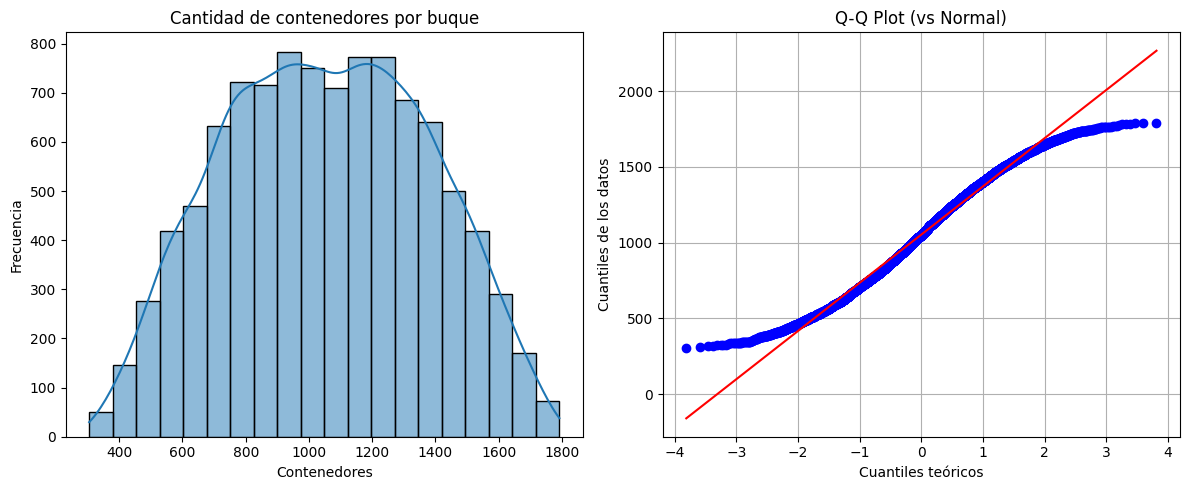

In [15]:
import pandas as pd

df1 = pd.read_csv(f"{1}_{25}_{3.0}_{10}_log.csv", sep=";",decimal=",")
df2 = pd.read_csv(f"{2}_{25}_{3.0}_{10}_log.csv", sep=";",decimal=",")
df3 = pd.read_csv(f"{1}_{25}_{2.5}_{10}_log.csv", sep=";",decimal=",")
df4 = pd.read_csv(f"{2}_{25}_{2.5}_{10}_log.csv", sep=";",decimal=",")
df5 = pd.read_csv(f"{1}_{25}_{2.0}_{10}_log.csv", sep=";",decimal=",")
df6 = pd.read_csv(f"{2}_{25}_{2.0}_{10}_log.csv", sep=";",decimal=",")
#df7 = pd.read_csv(f"{1}_{50}_{3.0}_{10}_log.csv", sep=";",decimal=",")
#df8 = pd.read_csv(f"{2}_{50}_{3.0}_{10}_log.csv", sep=";",decimal=",")

verificar_distribuciones(df1)

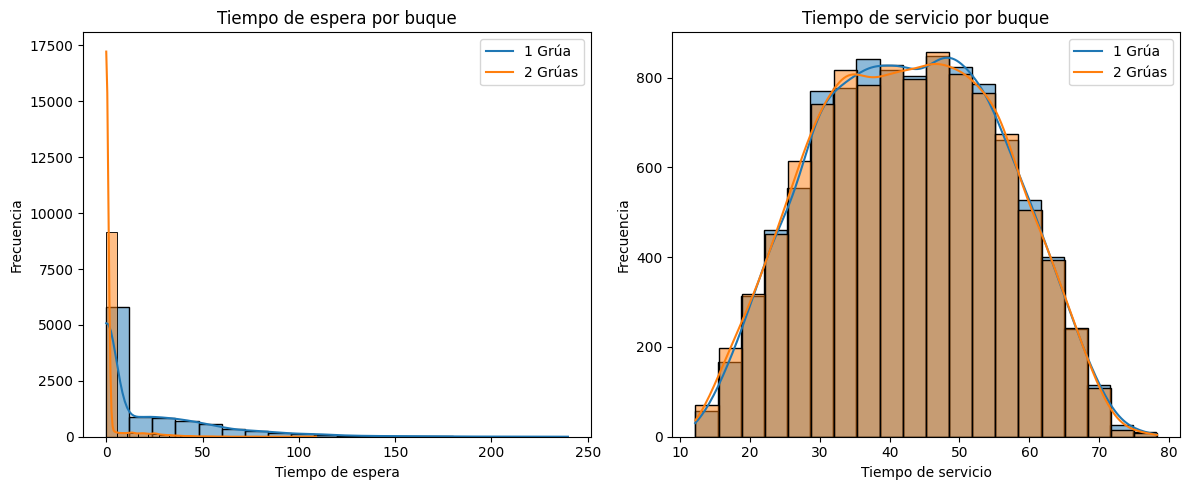

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Graficar histograma + KDE
sns.histplot(df1['tiempo_espera'], kde=True, bins=20, ax=axs[0])
sns.histplot(df2['tiempo_espera'], kde=True, bins=20, ax=axs[0])
axs[0].set_title("Tiempo de espera por buque")
axs[0].set_xlabel("Tiempo de espera")
axs[0].set_ylabel("Frecuencia")
axs[0].legend(["1 Grúa", "2 Grúas"])

# Crear el Q-Q plot
# Graficar histograma + KDE
sns.histplot(df1['tiempo_servicio'], kde=True, bins=20, ax=axs[1])
sns.histplot(df2['tiempo_servicio'], kde=True, bins=20, ax=axs[1])
axs[1].set_title("Tiempo de servicio por buque")
axs[1].set_xlabel("Tiempo de servicio")
axs[1].set_ylabel("Frecuencia")
axs[1].legend(["1 Grúa", "2 Grúas"])


plt.tight_layout()
plt.show()


In [17]:
from scipy.stats import ks_2samp

# Prueba KS entre ambas muestras
resultado = ks_2samp(df1['tiempo_espera'], df2['tiempo_espera'])

# H0: las dos muestras viene de la misma distribucion
# H1: ambas muestras viene de distribuciones continuas divergentes
# por supuesta al tener dos gruas, el tiempo de espera deberia se menor, por lo que se valida este supuesto. Si se acepta la hipotesis alternativa hay indicios claros de que el tiempo
# de espera es menor al considerar dos gruas

print("Estadístico KS:", resultado.statistic)
print("Valor p:", resultado.pvalue)


Estadístico KS: 0.3881
Valor p: 0.0


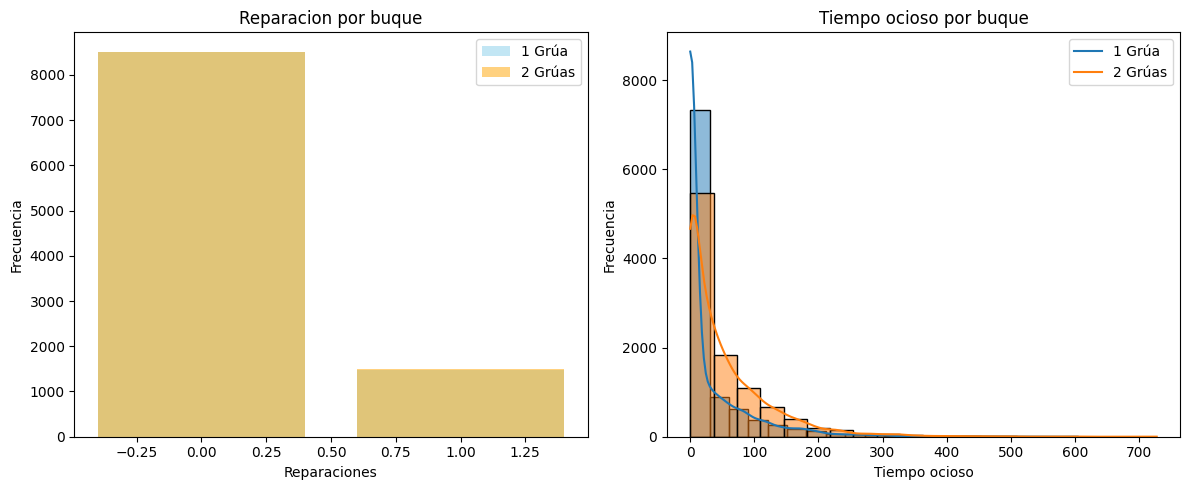

In [36]:
# Dado que el tiempo de espera disminuye al considerar dos gruas, el tiempo ocioso deberia aumentar ya que se tiene en cuenta una poblacion finita de barcos.
# otra consecuencia de ello es que la cantidad de reparaciones deberia ser igual en ambos casos. Esto debido a que la cantidad de barcos se distribuye de forma equitativa entre las gruas
# disminuyendo su estress.

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

conteo = Counter(df1['reparacion'])

# Extraer claves y valores
categorias1 = list(conteo.keys())
frecuencias1 = list(conteo.values())

conteo = Counter(df2['reparacion'])

# Extraer claves y valores
categorias2 = list(conteo.keys())
frecuencias2 = list(conteo.values())

# Graficar histograma + KDE
axs[0].bar(categorias1, frecuencias1, color='skyblue', alpha=0.5)
axs[0].bar(categorias2, frecuencias2, color='orange', alpha=0.5)
axs[0].set_title("Reparacion por buque")
axs[0].set_xlabel("Reparaciones")
axs[0].set_ylabel("Frecuencia")
axs[0].legend(["1 Grúa", "2 Grúas"])

# Crear el Q-Q plot
# Graficar histograma + KDE
sns.histplot(df1['tiempo_ocioso'], kde=True, bins=20, ax=axs[1])
sns.histplot(df2['tiempo_ocioso'], kde=True, bins=20, ax=axs[1])
axs[1].set_title("Tiempo ocioso por buque")
axs[1].set_xlabel("Tiempo ocioso")
axs[1].set_ylabel("Frecuencia")
axs[1].legend(["1 Grúa", "2 Grúas"])


plt.tight_layout()
plt.show()

In [41]:

from scipy.stats import chi2_contingency

# Contar frecuencias por grupo
conteo1 = Counter(df1['reparacion'])
conteo2 = Counter(df2['reparacion'])

# Unir en DataFrame para formar tabla de contingencia
categorias = sorted(set(df1['reparacion'] + df2['reparacion']))
tabla = pd.DataFrame({
    'Grupo1': [conteo1.get(cat, 0) for cat in categorias],
    'Grupo2': [conteo2.get(cat, 0) for cat in categorias]
}, index=categorias)

tabla = tabla[(tabla.sum(axis=1) > 0)]

print("Tabla de contingencia:")
print(tabla)

# Prueba chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla.T)

print(f"\nChi² = {chi2:.3f}")
print(f"p-value = {p:.3f}")

# H0: ambas muestras siguen la misma distribucion
# H1: las distribuciones de ambas muestras categoricas son distintas

# Prueba KS entre ambas muestras
resultado = ks_2samp(df1['tiempo_ocioso'], df2['tiempo_ocioso'])

# H0: las dos muestras viene de la misma distribucion
# H1: ambas muestras viene de distribuciones continuas divergentes

print("Estadístico KS:", resultado.statistic)
print("Valor p:", resultado.pvalue)

# El valo-p de la prueba de contingencia Chi-cuadrado es 0.937, con un nivel de confianza de 95% no hay evidencia suficiente para rechazar H0,
# i.e. Ambas muestras surgen de la misma distribucion. Por lo tanto queda validado el supuesto de que la cantidad de reparaciones debe ser igual en ambos casos.

# Para la segunda prueba de KS el valor p=0.0<0.05 se rechaza H0 debido a que hay evidencia de que las muestras vienen de distribuciones diferentes. En este sentido, queda validado el
# supuesto de que el tiempo ocioso es significativamente mayor al tener dos gruas.


Tabla de contingencia:
   Grupo1  Grupo2
0    8515    8510
1    1485    1490

Chi² = 0.006
p-value = 0.937
Estadístico KS: 0.3881
Valor p: 0.0


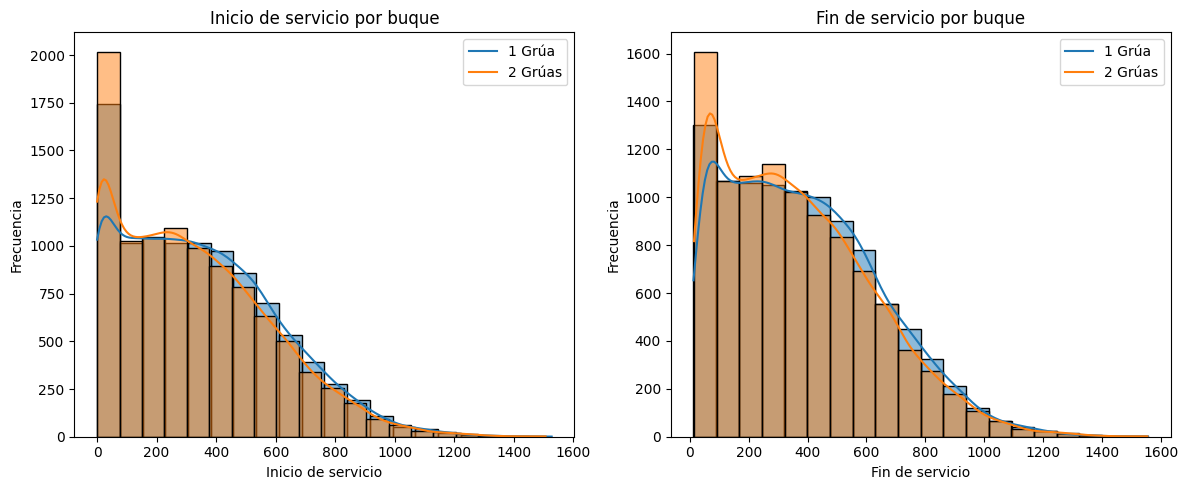

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Graficar histograma + KDE
sns.histplot(df1['inicio_servicio(ts)'], kde=True, bins=20, ax=axs[0])
sns.histplot(df2['inicio_servicio(ts)'], kde=True, bins=20, ax=axs[0])
axs[0].set_title("Inicio de servicio por buque")
axs[0].set_xlabel("Inicio de servicio")
axs[0].set_ylabel("Frecuencia")
axs[0].legend(["1 Grúa", "2 Grúas"])

# Crear el Q-Q plot
# Graficar histograma + KDE
sns.histplot(df1['fin_servicio(ts)'], kde=True, bins=20, ax=axs[1])
sns.histplot(df2['fin_servicio(ts)'], kde=True, bins=20, ax=axs[1])
axs[1].set_title("Fin de servicio por buque")
axs[1].set_xlabel("Fin de servicio")
axs[1].set_ylabel("Frecuencia")
axs[1].legend(["1 Grúa", "2 Grúas"])


plt.tight_layout()
plt.show()

# Análisis de resultado

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.read_csv(f"{1}_{25}_{3.0}_{10}_log.csv", sep=";",decimal=",")
df2 = pd.read_csv(f"{2}_{25}_{3.0}_{10}_log.csv", sep=";",decimal=",")
df3 = pd.read_csv(f"{1}_{25}_{2.5}_{10}_log.csv", sep=";",decimal=",")
df4 = pd.read_csv(f"{2}_{25}_{2.5}_{10}_log.csv", sep=";",decimal=",")
df5 = pd.read_csv(f"{1}_{25}_{2.0}_{10}_log.csv", sep=";",decimal=",")
df6 = pd.read_csv(f"{2}_{25}_{2.0}_{10}_log.csv", sep=";",decimal=",")
df7 = pd.read_csv(f"{1}_{50}_{3.0}_{10}_log.csv", sep=";",decimal=",")
df8 = pd.read_csv(f"{2}_{50}_{3.0}_{10}_log.csv", sep=";",decimal=",")

In [ ]:
def calcular_promedio_por_ciclo(df, variable):
    """
    Calcula el promedio por ciclo y el promedio global para una variable dada.

    Parámetros:
        df (pd.DataFrame): DataFrame con los resultados de simulaciones.
        variable (str): Nombre de la columna a analizar.

    Retorna:
        promedio_global (float): Promedio global de la variable entre ciclos.
        std_global (float): Desvío estándar de la variable entre ciclos.
        promedios_por_ciclo (pd.Series): Promedio de la variable por ciclo.
    """
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no existe en el DataFrame.")

    # Asegurar que la columna sea numérica
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

    # Agrupar por ciclo y calcular promedio por simulación
    promedios_por_ciclo = df.groupby("ciclo")[variable].mean()

    # Promedio y desvío global entre ciclos
    promedio_global = promedios_por_ciclo.mean()
    std_global = promedios_por_ciclo.std()

    print(f"🔎 Variable: {variable}")
    print(f"Promedio global entre ciclos: {promedio_global:.2f}")
    print(f"Desvío estándar entre ciclos: {std_global:.2f}")

    return promedio_global, std_global, promedios_por_ciclo


def contar_eventos_binarios(df, columna):
    resumen = df.groupby("ciclo")[columna].sum()
    promedio = resumen.mean()
    desvio = resumen.std()
    return promedio, desvio, resumen



In [ ]:
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "tiempo_total_operacion")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "tiempo_total_operacion")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "tiempo_total_operacion")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "tiempo_total_operacion")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "tiempo_total_operacion")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "tiempo_total_operacion")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "tiempo_total_operacion")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "tiempo_total_operacion")

print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "tiempo_espera")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "tiempo_espera")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "tiempo_espera")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "tiempo_espera")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "tiempo_espera")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "tiempo_espera")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "tiempo_espera")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "tiempo_espera")

print("####################")
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "tiempo_servicio")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "tiempo_servicio")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "tiempo_servicio")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "tiempo_servicio")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "tiempo_servicio")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "tiempo_servicio")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "tiempo_servicio")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "tiempo_servicio")

print("####################")
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "tiempo_ocioso")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "tiempo_ocioso")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "tiempo_ocioso")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "tiempo_ocioso")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "tiempo_ocioso")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "tiempo_ocioso")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "tiempo_ocioso")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "tiempo_ocioso")

print("####################")
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "peso_total_operado")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "peso_total_operado")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "peso_total_operado")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "peso_total_operado")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "peso_total_operado")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "peso_total_operado")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "peso_total_operado")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "peso_total_operado")

print("####################")
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "peso_x_hora")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "peso_x_hora")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "peso_x_hora")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "peso_x_hora")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "peso_x_hora")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "peso_x_hora")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "peso_x_hora")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "peso_x_hora")

print("####################")
print("{1}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "peso_medio_llenos_total")
print("{2}_{25}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "peso_medio_llenos_total")
print("{1}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "peso_medio_llenos_total")
print("{2}_{25}_{2.5}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "peso_medio_llenos_total")
print("{1}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "peso_medio_llenos_total")
print("{2}_{25}_{2}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "peso_medio_llenos_total")
print("{1}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "peso_medio_llenos_total")
print("{2}_{50}_{3}_{10}")
promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "peso_medio_llenos_total")

#print("####################")
#print("{1}_{25}_{3}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df1, "peso_x_hora_medio_lleno")
#print("{2}_{25}_{3}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df2, "peso_x_hora_medio_lleno")
#print("{1}_{25}_{2.5}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df3, "peso_x_hora_medio_lleno")
#print("{2}_{25}_{2.5}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df4, "peso_x_hora_medio_lleno")
#print("{1}_{25}_{2}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df5, "peso_x_hora_medio_lleno")
#print("{2}_{25}_{2}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df6, "peso_x_hora_medio_lleno")
#print("{1}_{50}_{3}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df7, "peso_x_hora_medio_lleno")
#print("{2}_{50}_{3}_{10}")
#promedio, desvio, detalle = calcular_promedio_por_ciclo(df8, "peso_x_hora_medio_lleno")


print("####################")
print("{1}_{25}_{3}_{10}")
prom, std, detalle = contar_eventos_binarios(df1, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df1, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df1, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))


print("####################")
print("{2}_{25}_{3}_{10}")
prom, std, detalle = contar_eventos_binarios(df2, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df2, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df2, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("{1}_{25}_{2.5}_{10}")
prom, std, detalle = contar_eventos_binarios(df3, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df3, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df3, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("{2}_{25}_{2.5}_{10}")
prom, std, detalle = contar_eventos_binarios(df4, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df4, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df4, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("{1}_{25}_{2}_{10}")
prom, std, detalle = contar_eventos_binarios(df5, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df5, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df5, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("{2}_{25}_{2}_{10}")
prom, std, detalle = contar_eventos_binarios(df6, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df6, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df6, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("1}_{50}_{3}_{10}")
prom, std, detalle = contar_eventos_binarios(df7, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df7, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df7, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

print("####################")
print("2}_{50}_{3}_{10}")
prom, std, detalle = contar_eventos_binarios(df8, "reparacion")
print("Reparaciones promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df8, "buque_espero_T_F")
print("Buques que esperaron promedio:", round(prom, 2), "| Desvío:", round(std, 2))

prom, std, detalle = contar_eventos_binarios(df8, "grua_ocioso_T_F")
print("Grúa ociosa promedio:", round(prom, 2), "| Desvío:", round(std, 2))

{1}_{25}_{3}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 21.92
Desvío estándar entre ciclos: 17.98
{2}_{25}_{3}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 1.88
Desvío estándar entre ciclos: 3.09
{1}_{25}_{2.5}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 29.79
Desvío estándar entre ciclos: 23.53
{2}_{25}_{2.5}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 2.57
Desvío estándar entre ciclos: 3.80
{1}_{25}_{2}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 40.91
Desvío estándar entre ciclos: 29.81
{2}_{25}_{2}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 4.04
Desvío estándar entre ciclos: 5.90
{1}_{50}_{3}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 3.93
Desvío estándar entre ciclos: 3.95
{2}_{50}_{3}_{10}
🔎 Variable: tiempo_espera
Promedio global entre ciclos: 0.25
Desvío estándar entre ciclos: 0.63
####################
{1}_{25}_{3}_{10}
🔎 Variable: tiempo_servicio
Promedio gl

In [ ]:
df1.columns.to_list()

['Unnamed: 0',
 'id',
 'llegada(ts)',
 'hora_navegacion_inicio(ts)',
 'tiempo_navegacion',
 'inicio_servicio(ts)',
 'fin_servicio(ts)',
 'tiempo_espera',
 'tiempo_servicio',
 'tiempo_ocioso',
 'peso_total_operado',
 'peso_x_hora',
 'clases_contenedores',
 'contenedores_carga',
 'contenedores_descarga',
 'contenedores_total',
 'proporcion_carga',
 'medio_llenos',
 'peso_medio_llenos_total',
 'peso_x_hora_medio_lleno',
 'proporcion_medio_llenos',
 'reparacion',
 'buque_espero_T_F',
 'grua_ocioso_T_F',
 'ciclo']

In [ ]:
import matplotlib.pyplot as plt
def calcular_proporcion_medio_llenos(df):
    resumen = df.groupby("ciclo")["proporcion_medio_llenos"].agg(['mean', 'std']).reset_index()
    resumen.columns = ["Ciclo", "Promedio", "Desvio"]
    return resumen
def graficar_proporcion_por_ciclo(df, config_label):
    resumen = calcular_proporcion_medio_llenos(df)
    plt.figure(figsize=(12, 5))
    plt.plot(resumen["Ciclo"], resumen["Promedio"], marker='o', label=f'Promedio - {config_label}')
    plt.fill_between(resumen["Ciclo"],
                     resumen["Promedio"] - resumen["Desvio"],
                     resumen["Promedio"] + resumen["Desvio"],
                     alpha=0.2, label=f'Desvío - {config_label}')
    plt.xlabel("Ciclo")
    plt.ylabel("Proporción de medio llenos")
    plt.title("Proporción de medio llenos por ciclo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


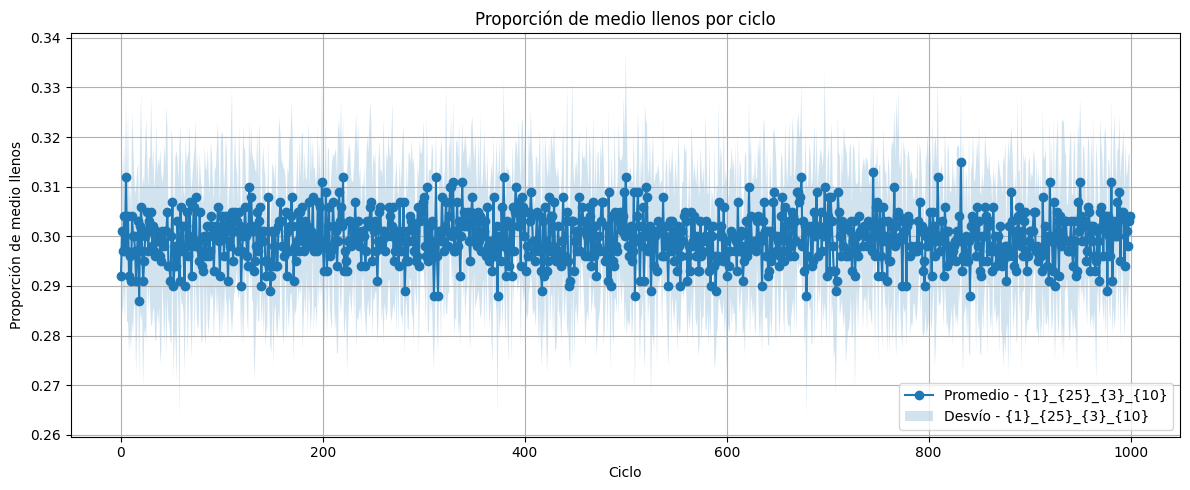

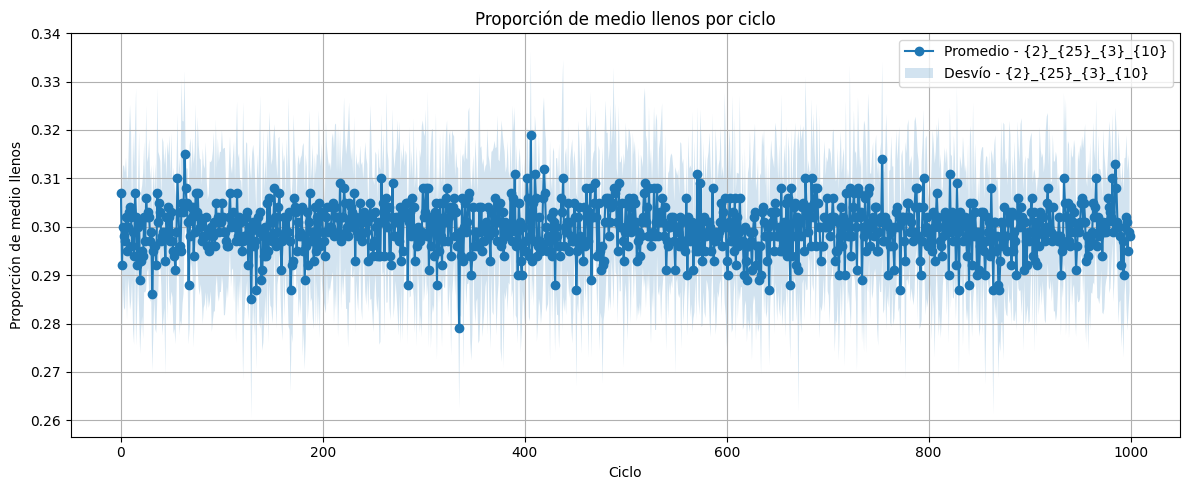

In [ ]:
graficar_proporcion_por_ciclo(df1, "{1}_{25}_{3}_{10}")
graficar_proporcion_por_ciclo(df2, "{2}_{25}_{3}_{10}")

In [ ]:
import seaborn as sns

def graficar_boxplot_proporcion(df, label_config):
    df_temp = df[["proporcion_medio_llenos", "ciclo"]].copy()
    df_temp["Configuracion"] = label_config
    return df_temp


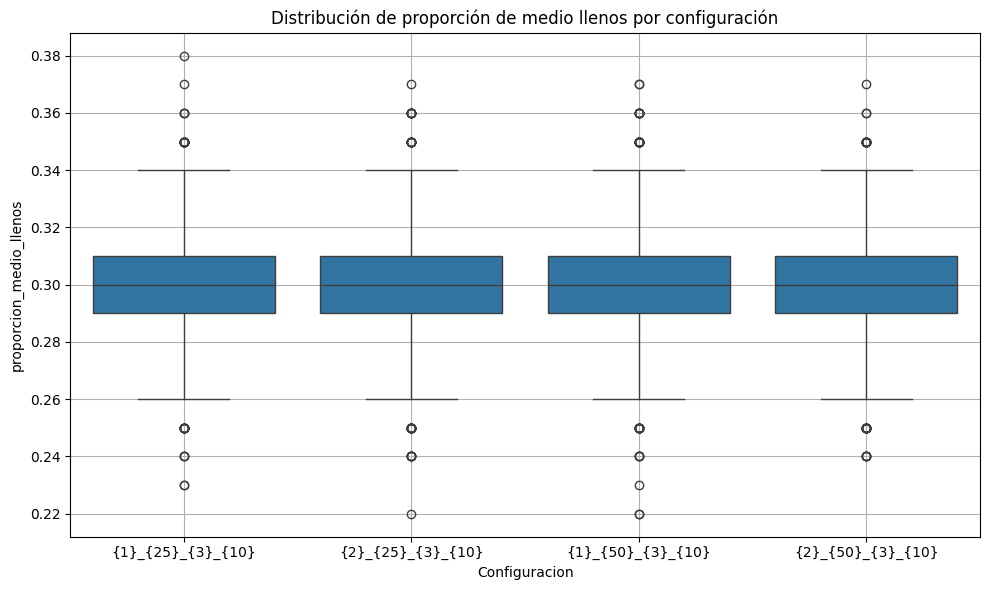

In [ ]:
df_plot = pd.concat([
    graficar_boxplot_proporcion(df1, "{1}_{25}_{3}_{10}"),
    graficar_boxplot_proporcion(df2, "{2}_{25}_{3}_{10}"),
    graficar_boxplot_proporcion(df1_2, "{1}_{50}_{3}_{10}"),
    graficar_boxplot_proporcion(df2_2, "{2}_{50}_{3}_{10}")
])

plt.figure(figsize=(10,6))
sns.boxplot(x="Configuracion", y="proporcion_medio_llenos", data=df_plot)
plt.title("Distribución de proporción de medio llenos por configuración")
plt.grid(True)
plt.tight_layout()
plt.show()


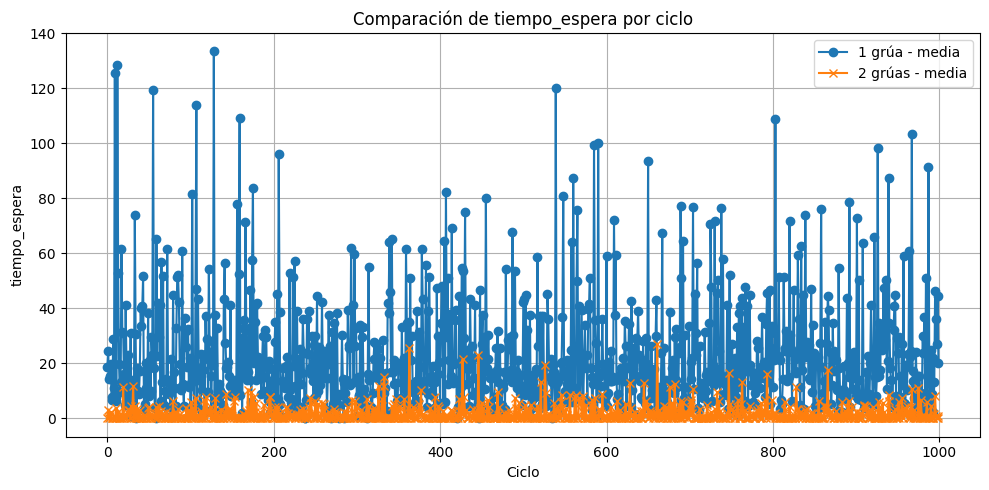

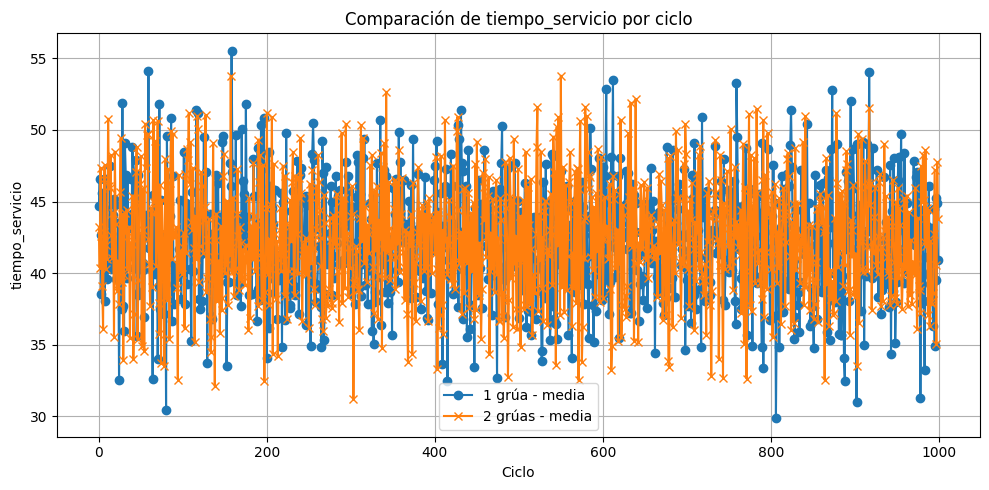

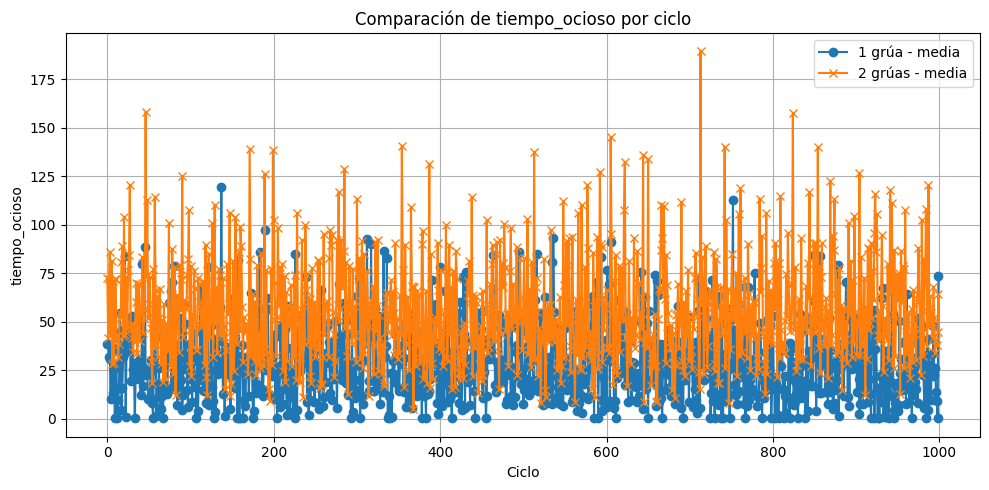

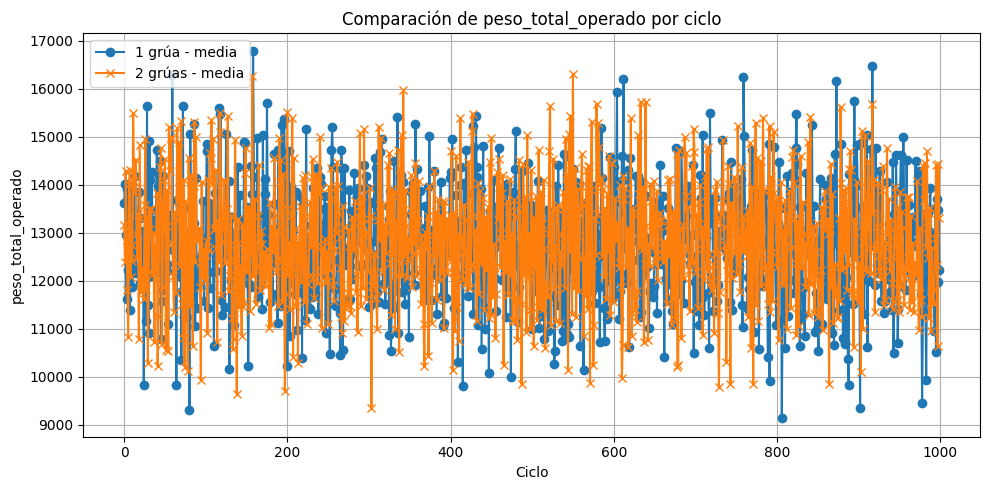

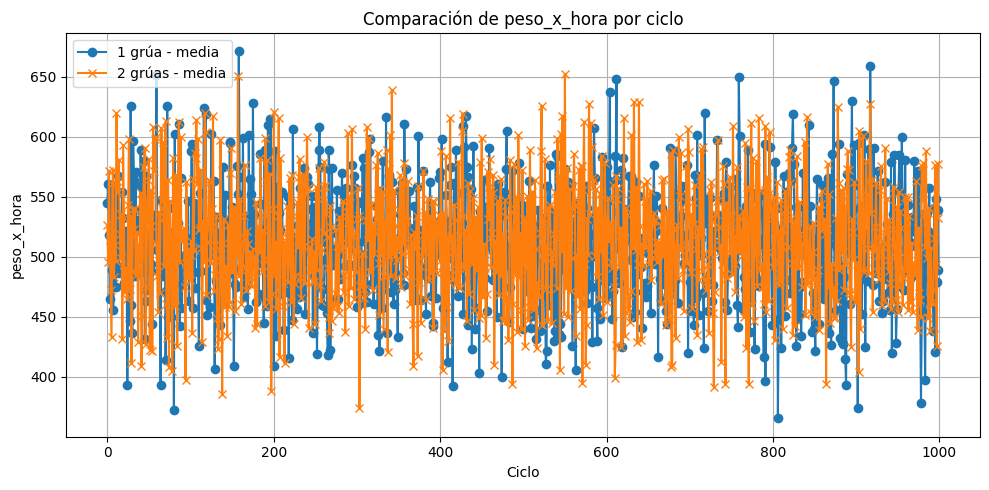

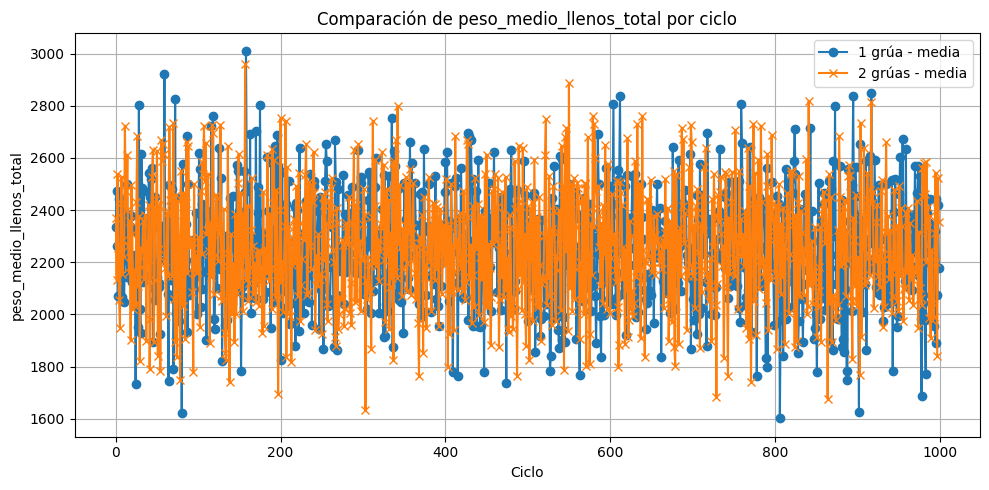

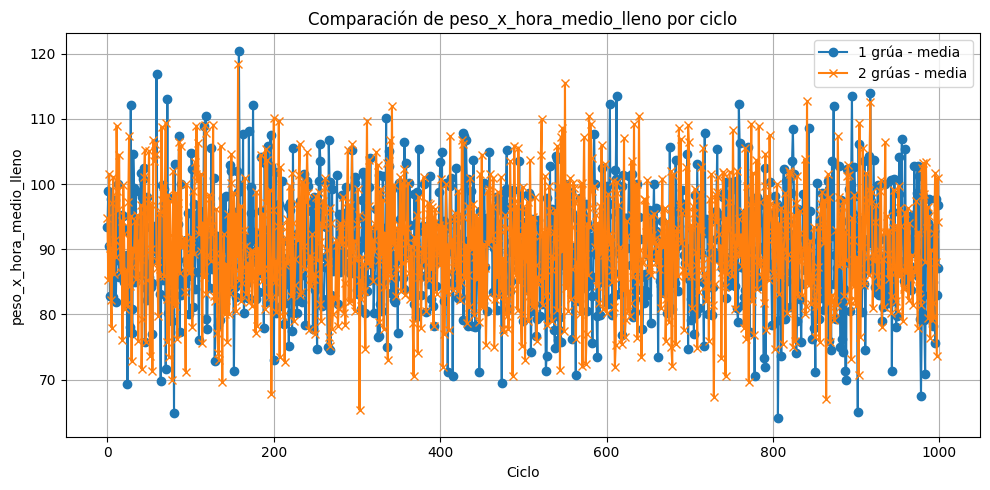

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Lista de variables a comparar
variables_analisis = [
    "tiempo_espera",
    "tiempo_servicio",
    "tiempo_ocioso",
    "peso_total_operado",
    "peso_x_hora",
    "peso_medio_llenos_total",
    "peso_x_hora_medio_lleno"
]

# Función para graficar una variable entre dos dataframes
def graficar_comparacion(df1, df2, var, nombre1="df1", nombre2="df2"):
    # Agrupamos por ciclo y calculamos el promedio
    media1 = df1.groupby("ciclo")[var].mean()
    media2 = df2.groupby("ciclo")[var].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(media1.index, media1.values, label=f"{nombre1} - media", marker='o')
    plt.plot(media2.index, media2.values, label=f"{nombre2} - media", marker='x')
    plt.title(f"Comparación de {var} por ciclo")
    plt.xlabel("Ciclo")
    plt.ylabel(var)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutamos para todas las variables
for var in variables_analisis:
    graficar_comparacion(df1, df2, var, nombre1="1 grúa", nombre2="2 grúas")


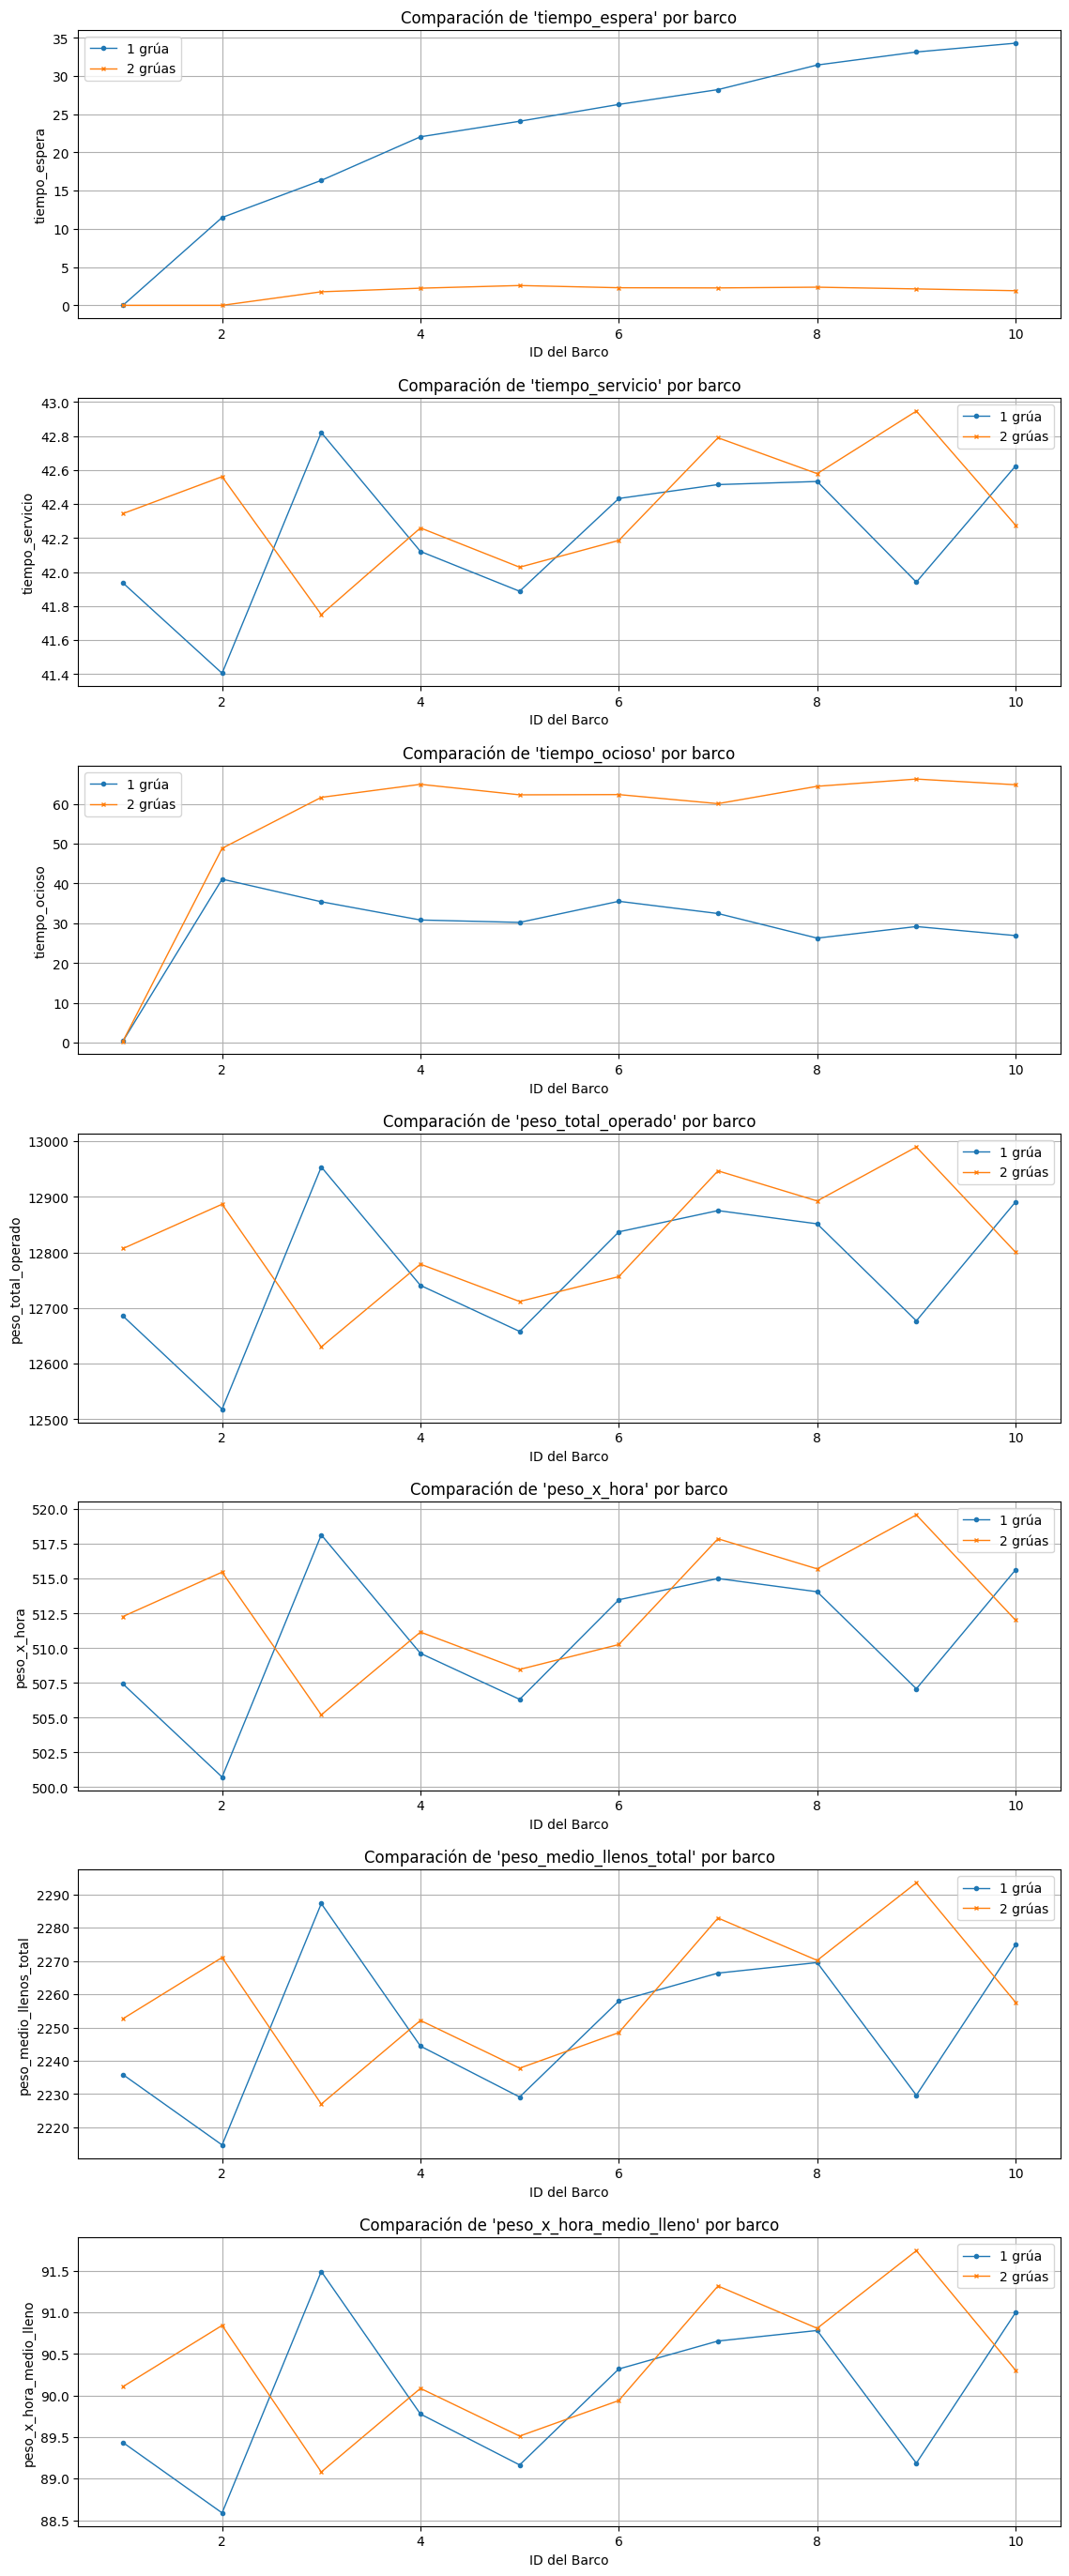

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurate de que los datos están cargados correctamente
# df1 = pd.read_csv("ruta/df1.csv")
# df2 = pd.read_csv("ruta/df2.csv")

# Variables a analizar
variables = [
    "tiempo_espera",
    "tiempo_servicio",
    "tiempo_ocioso",
    "peso_total_operado",
    "peso_x_hora",
    "peso_medio_llenos_total",
    "peso_x_hora_medio_lleno"
]

# Agrupamos por barco (id) y calculamos promedio para cada df
df1_promedios = df1.groupby("id")[variables].mean().reset_index()
df2_promedios = df2.groupby("id")[variables].mean().reset_index()

# Creamos gráficos comparativos para cada variable
fig, axs = plt.subplots(len(variables), 1, figsize=(12, 4 * len(variables)))
fig.tight_layout(pad=4.0)

for i, var in enumerate(variables):
    axs[i].plot(df1_promedios["id"], df1_promedios[var], label="1 grúa", marker="o", markersize=3, linewidth=1)
    axs[i].plot(df2_promedios["id"], df2_promedios[var], label="2 grúas", marker="x", markersize=3, linewidth=1)
    axs[i].set_title(f"Comparación de '{var}' por barco")
    axs[i].set_xlabel("ID del Barco")
    axs[i].set_ylabel(var)
    axs[i].legend()
    axs[i].grid(True)

plt.show()
